# Notebook to study edge of stability for the Associative memory model

I will keep this notebook minimalist, check the scratchpad notebook if you want to better understand the code.

In [11]:
import subprocess
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from scipy.linalg import eigh

sys.path.append('.')
from model import AssociativeMemory, get_embeddings

plt.rc('font', family='serif', size=8)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
plt.rc('text', usetex=usetex)
if usetex:
    plt.rc('text.latex', preamble=r'\usepackage{times}')
    
torch.manual_seed(0)

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


In [2]:
# hyparameters
n = 30
alpha = 0
epsilon = 0
d = 10

batch_size = 1
nb_epoch = 10000
T = nb_epoch * batch_size
lr = 1e-3

def f(x, epsilon=0):
    return x

# data
all_x = torch.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = f(all_x, epsilon)

# model
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True)
model = AssociativeMemory(E, U)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)

In [3]:
# training loop 
k = 10   # number of eigenvalues to track

train_loss = torch.zeros(nb_epoch)
train_loss_pop = torch.zeros(nb_epoch)
test_loss = torch.zeros(nb_epoch)
eigenvals = np.zeros((nb_epoch, k))
eigenvals_pop = np.zeros((nb_epoch, k))

for i in range(nb_epoch):
    # get batch of data
    x = torch.multinomial(proba, batch_size, replacement=True)
    y = f(x, epsilon)

    # compute loss
    score = model(x)
    loss = F.cross_entropy(score, y)
    
    # record statistics
    train_loss[i] = loss.item()
    with torch.no_grad():
        pred = model.fit(all_x)
        test_loss[i] = proba[pred != all_y].sum().item()

        # Hessian statistics
        score = model(all_x)
        log_likelihood = F.log_softmax(score, dim=1)
        log_likelihood = - log_likelihood[torch.arange(len(all_x)), all_y]
        log_likelihood *= proba
        train_loss_pop[i] = log_likelihood.sum()
        
        # record statistics
        train_loss[i] = loss.item()

    # Hessian statistics
    hessian = model.hessian(x)
    eigenvals[i] = eigh(hessian.numpy(), eigvals_only=True, subset_by_index=[d*d-k, d*d-1])
    population_hessian = model.hessian(all_x, proba)
    eigenvals_pop[i] = eigh(population_hessian.numpy(), eigvals_only=True, subset_by_index=[d*d-k, d*d-1])

    # update parameters with gradient descent
    loss.backward()
    optimizer.step()
    # scheduler.step()


In [27]:
@torch.jit.script
def ewma(x: torch.Tensor, theta: float):
    r = torch.zeros_like(x)
    r[0] = x[0]
    for i in range(1, x.shape[0]):
        r[i] = theta * r[i - 1] + (1 - theta) * x[i]
    return r

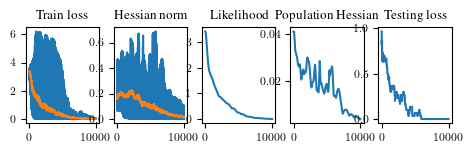

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(5.5, 1.25))
axes[0].plot(torch.arange(nb_epoch), train_loss)
smooth_train_loss = ewma(train_loss, .99)
axes[0].plot(torch.arange(nb_epoch), smooth_train_loss)
axes[0].set_title('Train loss')
axes[1].plot(np.arange(nb_epoch), eigenvals[:, -1])
smooth_hess = ewma(torch.tensor(eigenvals[:, -1]), .99)
axes[1].plot(torch.arange(nb_epoch), smooth_hess)
axes[1].set_title('Hessian norm')
axes[2].plot(torch.arange(nb_epoch), train_loss_pop)
axes[2].set_title('Likelihood')
axes[3].plot(np.arange(nb_epoch), eigenvals_pop[:, -1])
axes[3].set_title('Population Hessian')
axes[4].plot(torch.arange(nb_epoch), test_loss)
axes[4].set_title('Testing loss')
# fig.suptitle('Training dynamics plots')
fig.savefig('eos.pdf', bbox_inches='tight', pad_inches=0)